In [1]:
import Ramsey_ExperimentV2
import estimator
import numpy as np

In [1]:
import Ramsey_ExperimentV2
import random
import importlib
from tqdm import tqdm

h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n - 1)])
y_lornz = lambda a, x, w: np.pi * (2 * a / (a ** 2 + (x - w) ** 2) + 2 * a / (a ** 2 + (x + w) ** 2))
y_lornz_single = lambda a, x, w: (2 * a / ((a ** 2 + x ** 2) * 2 * np.pi))


def sinc(x_values):
    X = []
    for x in x_values:
        X.append((np.sin(2 * x * np.pi) / (2 * x * np.pi) if x != 0 else 1))
    return X


def fisher_inf(x, w, a):
    cos_wx_squared = np.cos(w * x) ** 2
    sin_wx_squared = np.sin(w * x) ** 2
    exp_ax = np.exp(a * x)

    term1 = x ** 2 * cos_wx_squared / (exp_ax + np.cos(w * x)) ** 2
    term2 = x ** 2 * sin_wx_squared / (exp_ax + np.cos(w * x)) ** 2

    return term1 + term2


def effective_hem(size, J, W):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        #Z.reverse()
        hem[i, i] = h(size, J, Z)
        hem[i, i] += sum([W[k] for k in range(size) if binary[k] == '1'])
    return hem

In [2]:
import numpy as np


def p(t, w, a):
    return 1 / 2 * (1 + np.cos(w * t) * np.exp(-a * t))


def pw(t, w, a):
    return - 1 / 2 * t * np.sin(w * t) * np.exp(-a * t)


def pww(t, w, a):
    return - 1 / 2 * t ** 2 * np.cos(w * t) * np.exp(-a * t)


def pa(t, w, a):
    return - 1 / 2 * t * np.cos(w * t) * np.exp(-a * t)


def paa(t, w, a):
    return 1 / 2 * t ** 2 * np.cos(w * t) * np.exp(-a * t)


def paw(t, w, a):
    return 1 / 2 * t ** 2 * np.sin(w * t) * np.exp(-a * t)


def fisher_matrix(t, w, a, shots):
    Iww = 0
    Iaa = 0
    Iwa = 0

    for i in range(len(t)):
        p0 = p(t[i], w, a)
        p1 = 1 - p0
        pw0 = pw(t[i], w, a)
        pw1 = -pw0
        pww0 = pww(t[i], w, a)
        pww1 = -pww0
        pa0 = pa(t[i], w, a)
        pa1 = -pa0
        paa0 = paa(t[i], w, a)
        paa1 = -paa0
        paw0 = paw(t[i], w, a)
        paw1 = -paw0

        if p0 == 0:
            p0 = 1e-10
        if p1 == 0:
            p1 = 1e-10

        # Iww -= shots[i] * (p0 * ((pww0 * p0 - pw0 ** 2) / p0 ** 2) + p1 * ((pww1 * p1 - pw1
        #                                                                     ** 2) / p1 ** 2))
        # Iaa -= shots[i] * (p0 * ((paa0 * p0 - pa0 ** 2) / p0 ** 2) + p1 * ((paa1 * p1 - pa1 ** 2) / p1 ** 2))
        # Iwa -= shots[i] * (p0 * ((paw0 * p0 - pw0 * pa0) / p0 ** 2) + p1 * ((paw1 * p1 - pw1 * pa1) / p1 ** 2))

        Iww += shots[i] * (p0 * ((pw0 ** 2) / p0 ** 2) + p1 * ((pw1 ** 2) / p1 ** 2))
        Iaa += shots[i] * (p0 * ((pa0 ** 2) / p0 ** 2) + p1 * ((pa1 ** 2) / p1 ** 2))
        Iwa += shots[i] * (p0 * ((pw0 * pa0) / p0 ** 2) + p1 * ((pw1 * pa1) / p1 ** 2))
    return np.array([[Iww, Iwa], [Iwa, Iaa]])



def lower_bound(f_mat):
    inv = np.linalg.inv(f_mat)
    inv = inv.reshape(2,2)
    w_var = np.sqrt(inv[0, 0])
    a_var = np.sqrt(inv[1, 1])

    #a_var = np.sqrt(inv[1, 1])
    return w_var, a_var



In [3]:
from scipy.optimize import minimize


def find_optimal_times(W, A, N, Total_Shots=1000):
    def model_func(params):
        t = params[0:N]
        shots = params[N:2 * N]
        Iww = [0] * len(W)
        Iaa = [0] * len(W)
        Iwa = [0] * len(W)

        for i in range(len(t)):
            for j in range(len(W)):
                w = W[j]
                a = A[j]
                p0 = p(t[i], w, a)
                p1 = 1 - p0
                pw0 = pw(t[i], w, a)
                pw1 = -pw0
                pww0 = pww(t[i], w, a)
                pww1 = -pww0
                pa0 = pa(t[i], w, a)
                pa1 = -pa0
                paa0 = paa(t[i], w, a)
                paa1 = -paa0
                paw0 = paw(t[i], w, a)
                paw1 = -paw0

                if p0 == 0:
                    p0 = 1e-10
                if p1 == 0:
                    p1 = 1e-10

                Iww[j] -= shots[i] * (p0 * ((pww0 * p0 - pw0 ** 2) / p0 ** 2) + p1 * ((pww1 * p1 - pw1
                                                                                    ** 2) / p1 ** 2))
                Iaa[j] -= shots[i] * (p0 * ((paa0 * p0 - pa0 ** 2) / p0 ** 2) + p1 * ((paa1 * p1 - pa1 ** 2) / p1 ** 2))
                Iwa[j] -= shots[i] * (p0 * ((paw0 * p0 - pw0 * pa0) / p0 ** 2) + p1 * ((paw1 * p1 - pw1 * pa1) / p1 ** 2))

        lower_w_bound = np.sum([10000 * Iaa[j] / (Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        lower_a_bound = np.sum([10000 * Iww[j] / (Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        return  np.mean([lower_w_bound,lower_a_bound])

    def shots_constraint(params):
        return np.sum(params[N:2 * N]) - Total_Shots

    # Define the constraint as a dictionary
    cons = ({'type': 'eq', 'fun': shots_constraint})
    initial_guess = np.concatenate([np.random.uniform(0, 0.01, N), np.full(N, Total_Shots / N)])
    result = minimize(model_func, initial_guess, method='trust-constr', bounds=[(0, 2*np.pi)] * N + [(0, 1000)] * N,
                      constraints=cons)
    return result.x


def process_result(result):
    times = result[0:N]
    shots = result[N:2 * N]

    grouped_times = []
    grouped_shots = []

    for i in range(len(times)):
        for j in range(len(grouped_times)):
            if abs(grouped_times[j] - times[i]) < 0.005:
                #grouped_times.append(times[i])
                grouped_shots[j] += shots[i]
                break
        else:
            grouped_times.append(times[i])
            grouped_shots.append(shots[i])

    paired = sorted(zip(grouped_times, grouped_shots))
    times = [x for x, _ in paired]
    shots = [int(round(y)) for _, y in paired]

    return times, shots


N = 2
Total_Shots = N * 500
w = [1]
a = [0.5]
result = find_optimal_times(w, a, N, Total_Shots)
optimal_times, optimal_shots = process_result(result)

regular_times = np.linspace(0, 3*np.pi, N)
print("Optimal times = ", optimal_times)
print("Optimal shots = ", optimal_shots)
fishers = [fisher_matrix(optimal_times, w[i], a[i], [Total_Shots/N]*N) for i in range(len(w))]
bound_w, bound_a = lower_bound(fishers)
print("lower_bound = ", (bound_w + bound_a)/(w[0]**2 + a[0]**2))

Optimal times =  [1.4073100245409906, 2.8943456744795357]
Optimal shots =  [500, 500]
lower_bound =  0.10272416857300874


C:\Users\user\PycharmProjects\ML_Crosstalk\venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


1.0391108070782686


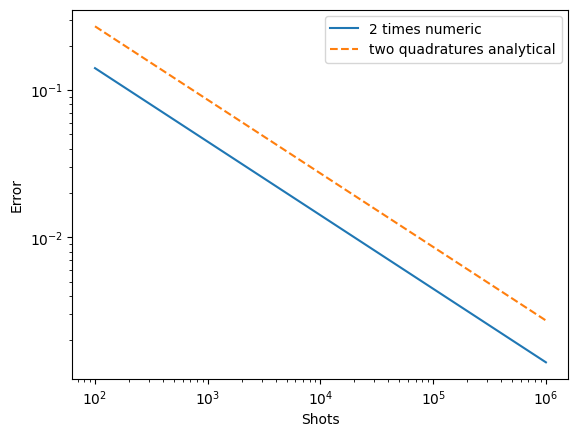

In [4]:
import matplotlib.pyplot as plt
shots= np.logspace(2,6,num=6-2+1,base=10,dtype='int')
bounds = []
for s in shots:
    mat = fisher_matrix(optimal_times, w[0], a[0], [s]*N)
    bounds.append(lower_bound(mat)[0])
plt.plot(shots, bounds, label='2 times numeric')

plt.plot(shots, np.e / np.sqrt(shots), '--', label='two quadratures analytical')

plt.legend()
plt.xlabel('Shots')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
print(bounds[4]/(np.e*a[0]/np.sqrt(shots[4])))


In [5]:
T1 = np.linspace(0.1, np.pi, 100)
T2 = np.linspace(0.1, np.pi, 100)
w = [1]
a = [1]
bound = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        t = [T1[i], T2[j]]
        # var = np.sum([2*np.trace(np.linalg.inv(fishers[i])) / (w[i]) for i in range(len(w)) ])
        try:
            fishers = [fisher_matrix(t, w[k], a[k], [Total_Shots/N]*N) for k in range(len(w))]
            bound_w, bound_a = lower_bound(fishers)
            bound[i,j] = (bound_w + bound_a)
        except:
            bound[i,j] = np.nan
min_val = np.nanmin(bound)
# bound = bound/min_val

C:\Users\user\AppData\Local\Temp\ipykernel_16908\1796554785.py:67: RuntimeWarning: invalid value encountered in sqrt
  w_var = np.sqrt(inv[0, 0])
C:\Users\user\AppData\Local\Temp\ipykernel_16908\1796554785.py:68: RuntimeWarning: invalid value encountered in sqrt
  a_var = np.sqrt(inv[1, 1])


C:\Users\user\AppData\Local\Temp\ipykernel_16908\481916303.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


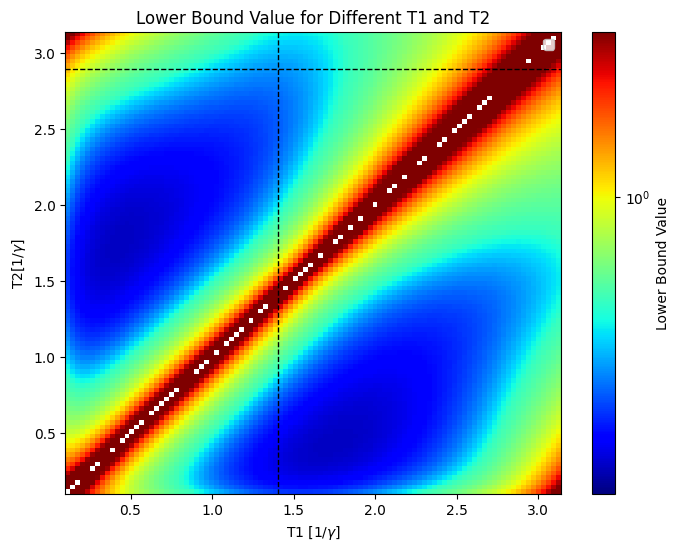

In [6]:
from matplotlib.colors import LogNorm, SymLogNorm

# Assume `bound` is already calculated as shown in the code snippet
# Here’s how to plot it as a heatmap
def piecewise_transform(value):
    if value <= 1:
        return value  # Linear for small values
    else:
        return np.log10(value) + 1  # Logarithmic for larger values

# Apply the transformation to your data
transformed_bound = np.vectorize(piecewise_transform)(bound)


plt.figure(figsize=(8, 6))
plt.imshow(bound, extent=[0.1, np.pi, 0.1, np.pi], origin='lower', aspect='auto', cmap='jet', norm=SymLogNorm(linthresh=0.5, vmin=0.25, vmax=3))
plt.colorbar(label='Lower Bound Value')

# norm=LogNorm(vmin=0.1, vmax=10))
# Draw the vertical and horizontal lines
plt.axvline(x=optimal_times[0], color='black', linestyle='--', linewidth=1)
plt.axhline(y=optimal_times[1], color='black', linestyle='--', linewidth=1)

# Label axes and title
plt.xlabel('T1 [1/$\gamma$]')
plt.ylabel('T2[1/$\gamma$]')
plt.title('Lower Bound Value for Different T1 and T2')

# Add a legend
plt.legend()

plt.show()



In [63]:
A=[1]
W = np.linspace(0, 3, 26)
W = np.delete(W, 0)

ratio = []
fisher_bounds = []
quads_bounds = []
for w in W:
    result = find_optimal_times([w], A, 2, Total_Shots)
    optimal_times, optimal_shots = process_result(result)

    mat = fisher_matrix(optimal_times, w, A[0], [5000]*2)
    fisher_bound = lower_bound(mat)[0]

    quads_bound = np.e * A[0]/np.sqrt(5000) #TODO check if division is correct
    fisher_bounds.append(fisher_bound)
    quads_bounds.append(quads_bound)
    ratio.append(fisher_bound/quads_bound)


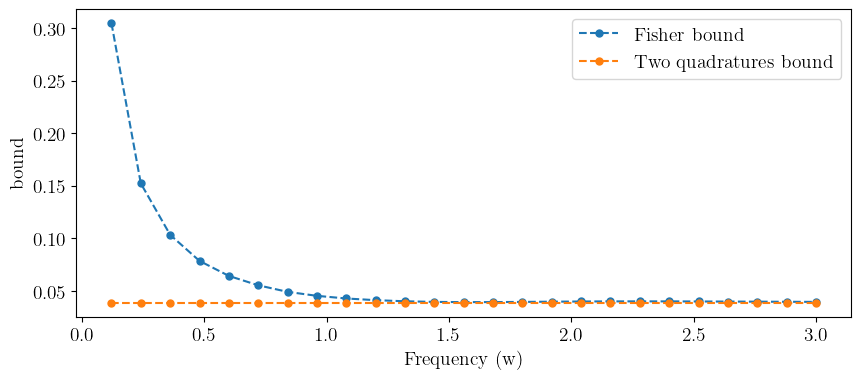

In [64]:
plt.figure(figsize=(10, 4))  # Adjust the figure size to make the plot longer
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.plot(W, fisher_bounds, linestyle='--', marker='o', markersize=5, label='Fisher bound')
plt.plot(W, quads_bounds, linestyle='--', marker='o', markersize=5, label='Two quadratures bound')
plt.xlabel('Frequency (w)')
plt.ylabel('bound')
plt.legend()
plt.show()


In [59]:
W=[1]
A = np.linspace(0, 3, 26)
A = np.delete(A, 0)

ratio = []
fisher_bounds = []
quads_bounds = []
for a in A:
    result = find_optimal_times(W,[a], 2, Total_Shots)
    optimal_times, optimal_shots = process_result(result)

    mat = fisher_matrix(optimal_times, W[0], a, [5000]*2)
    # fisher_bound = lower_bound(mat)[0]+lower_bound(mat)[1]
    fisher_bound = lower_bound(mat)[0]

    quads_bound = np.e * a/np.sqrt(5000) #TODO check if division is correct
    fisher_bounds.append(fisher_bound)
    quads_bounds.append(quads_bound)
    ratio.append(fisher_bound/quads_bound)


C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


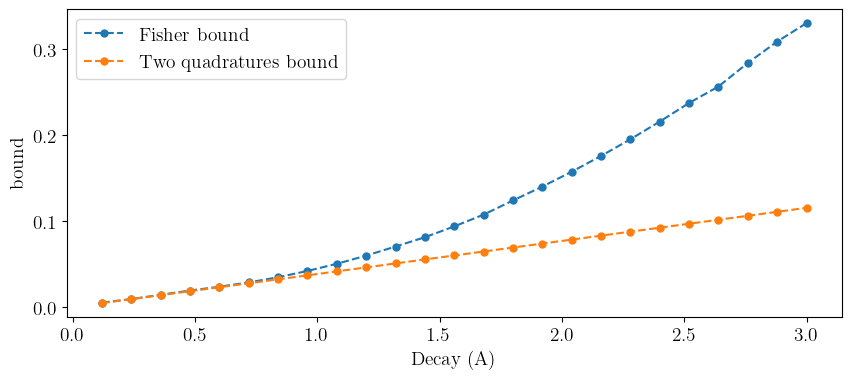

In [60]:
plt.figure(figsize=(10, 4))  # Adjust the figure size to make the plot longer
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.plot(A, fisher_bounds, linestyle='--', marker='o', markersize=5, label='Fisher bound')
plt.plot(A, quads_bounds, linestyle='--', marker='o', markersize=5, label='Two quadratures bound')

plt.xlabel('Decay (A)')
plt.ylabel('bound')
plt.legend()
plt.show()


In [78]:
A=[1]
W = np.linspace(0, 2, 26)
W = np.delete(W, 0)

ratio = []
fisher_bounds = []
quads_bounds = []


result = find_optimal_times([1], [1], N, Total_Shots)
optimal_times, optimal_shots = process_result(result)

for w in W:

    mat = fisher_matrix(optimal_times, w, A[0], [5000]*2)
    fisher_bound = lower_bound(mat)[0]
    quads_bound = np.e /np.sqrt(5000) #TODO check if division is correct
    fisher_bounds.append(fisher_bound)
    quads_bounds.append(quads_bound)
    ratio.append(fisher_bound/quads_bound)


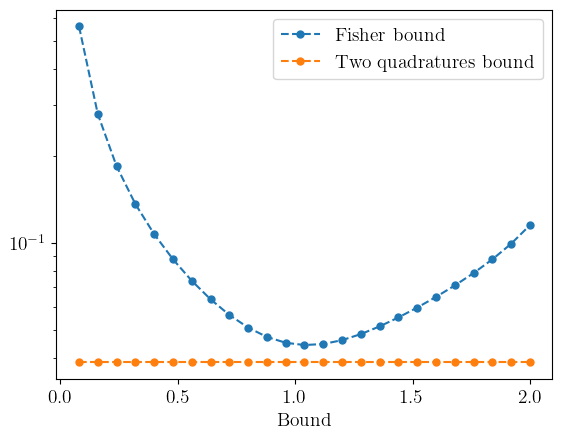

In [79]:

plt.plot(W, fisher_bounds, linestyle='--', marker='o', markersize=5, label='Fisher bound')
plt.plot(W, quads_bounds, linestyle='--', marker='o', markersize=5, label='Two quadratures bound')
plt.yscale('log')
plt.xlabel('W')
plt.xlabel('Bound')
plt.legend()

In [86]:
print(np.min(fisher_bounds)/np.min(quads_bounds))

1.149307164455364


In [13]:


#optimal_times, optimal_shots = process_result(result)
print("Optimal times = ", optimal_times)
print("Optimal shots = ", optimal_shots)
print(sum(optimal_shots))
optimal_w_bound = np.sum(lower_bound(fisher_matrix(optimal_times, w, a, optimal_shots)))
regular_w_bound = np.sum(lower_bound(fisher_matrix(regular_times, w, a, N * [100])))
print("Optimal w bound = ", optimal_w_bound)
print("Regular w bound = ", regular_w_bound)

Optimal times =  [0.4439408326439209, 1.784695435782728]
Optimal shots =  [462, 538]
1000
Optimal w bound =  7.043522472890404
Regular w bound =  nan


C:\Users\user\AppData\Local\Temp\ipykernel_29116\1796554785.py:67: RuntimeWarning: invalid value encountered in sqrt
  w_var = np.sqrt(inv[0, 0])
C:\Users\user\AppData\Local\Temp\ipykernel_29116\1796554785.py:68: RuntimeWarning: invalid value encountered in sqrt
  a_var = np.sqrt(inv[1, 1])


In [14]:
##approximation:
from scipy.optimize import minimize


def find_optimal_times_app(W, A, t):
    def model_func(t):
        Iww = [0] * len(W)
        Iaa = [0] * len(W)
        Iwa = [0] * len(W)

        for i in range(len(t)):
            for j in range(len(W)):
                w = W[j]
                a = A[j]
                Iww[j] += t[i]**2 * np.sin(w * t[i])**2 * np.exp(-2 * a * t[i])
                Iaa[j] += t[i]**2 * np.cos(w * t[i])**2 * np.exp(-2 * a * t[i])
                Iwa[j] += t[i]**2 * np.sin(w * t[i]) * np.cos(w * t[i]) * np.exp(-2 * a * t[i])




        lower_w_bound = np.sum([Iaa[j] / (0.001 if Iaa[j] * Iww[j] - Iwa[j] ** 2 == 0 else Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        lower_a_bound = np.sum([Iww[j] / (0.001 if Iaa[j] * Iww[j] - Iwa[j] ** 2 == 0 else Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        return lower_w_bound + lower_a_bound


    initial_guess = np.random.uniform(0.1, np.pi, t)
    result  = minimize(model_func, initial_guess,method='trust-constr', bounds=[(0, np.pi)] * t)
    return result.x


t = 4
w = [1,5]
a = [1,5]
optimal_times = find_optimal_times_app(w, a, t)

print("Optimal times = ", optimal_times)
fishers = [fisher_matrix(optimal_times, w[i], a[i], [1000]*t) for i in range(len(w))]
print("var = ", np.sum([t*np.trace(np.linalg.inv(fishers[i])) / (w[i]) for i in range(len(w)) ]))

Optimal times =  [0.40820213 0.13990133 1.70173514 0.40820212]
var =  0.3555995711966418


In [15]:
from sympy import lambdify
## Normal approximation
from sympy import symbols, cos, sin, exp, sqrt
from scipy.optimize import minimize

# Define the symbols
t0, t1 = symbols('t0 t1', real=True, positive=True)

# Parameters
omega_value = gamma_value = w =a = 1

# Define the elements of the inverted matrix
I_00_expr = ((exp(2 * gamma_value * t1) * t0**2 * cos(omega_value * t0)**2 + exp(2 * gamma_value * t0) * t1**2 * cos(omega_value * t1)**2)
        * (1/sin(omega_value * (t0 - t1)))**2) / (t0**2 * t1**2)
I_11_expr = ((exp(2 * gamma_value * t1) * t0**2 * sin(omega_value * t0)**2 + exp(2 * gamma_value * t0) * t1**2 * sin(omega_value * t1)**2)
        * (1/sin(omega_value * (t0 - t1)))**2) / (t0**2 * t1**2)


# Define the function we want to find the minimum for
f_expr = sqrt(I_00_expr) + sqrt(I_11_expr)
#f_expr = sqrt(I_00_expr)
# Convert the symbolic expression to a numerical function
f_numeric = lambdify((t0, t1), f_expr, modules=['numpy'])

# Define a function to be minimized
def f_to_minimize(x):
    # x is a vector where x[0] = t0 and x[1] = t1
    return f_numeric(x[0], x[1])

# Initial guess (we avoid starting at 0 to prevent division by zero)
initial_guess = [0.1, 1]

# Perform the minimization
result = minimize(f_to_minimize, initial_guess, bounds=[(0.1, 5), (0.1, 5)])

# Extract the results
t0_min, t1_min = result.x
min_value = result.fun

print(t0_min, t1_min, min_value)
print("approximated_bound = ",np.sum(lower_bound(fisher_matrix([t0_min,t1_min], w, a, [2500,2500]))))



0.1 1.0 20.245581863866434
approximated_bound =  0.19834662710958945


<lambdifygenerated-1>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return sqrt(t0**2*exp(2*t1)*sin(t0)**2 + t1**2*exp(2*t0)*sin(t1)**2)/(t0*t1*abs(sin(t0 - t1))) + sqrt(t0**2*exp(2*t1)*cos(t0)**2 + t1**2*exp(2*t0)*cos(t1)**2)/(t0*t1*abs(sin(t0 - t1)))


In [16]:
from sympy import symbols, cos, sin, exp, csc, sqrt, diff, solve

# Define the symbols
t0, t1, omega, gamma = symbols('t0 t1 omega gamma', real=True, positive=True)

# Define the elements of the inverted matrix
I_00 = ((exp(-2 * gamma * t1) * t0**2 * cos(omega * t0)**2 + exp(-2 * gamma * t0) * t1**2 * cos(omega * t1)**2)
        * csc(omega * (t0 - t1))**2) / (t0**2 * t1**2)
I_11 = ((exp(-2 * gamma * t1) * t0**2 * sin(omega * t0)**2 + exp(-2 * gamma * t0) * t1**2 * sin(omega * t1)**2)
        * csc(omega * (t0 - t1))**2) / (t0**2 * t1**2)

# Define the function we want to minimize
f = sqrt(I_00) + sqrt(I_11)

# Compute the derivative of the function with respect to both t0 and t1
df_dt0 = diff(f, t0)
df_dt1 = diff(f, t1)

# Find the critical points by setting the derivatives to zero
critical_points = solve((df_dt0, df_dt1), (t0, t1))

critical_points


KeyboardInterrupt: 

In [ ]:
VarA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
w=1
a = 1.5
t = np.linspace(0, 1*np.pi, 6000)  # time vector
# Defining f1, f2, f3
f1 = (np.cos(w*t) + 1j*np.sin(w*t)) * np.exp(-a*t)
f2 = (np.cos(1.5*w*t) + 1j*np.sin(1.5*w*t)) * np.exp(-a*t)
f3 = (np.cos(3.5*w*t) + 1j*np.sin(3.5*w*t)) * np.exp(-a*t)

# Updated Complex Function
real_part = (np.cos(w*t) + np.cos(1.5*w*t) + np.cos(3.5*w*t)) * np.exp(-a*t)
imaginary_part = (np.sin(w*t) + np.sin(1.5*w*t) + np.sin(3.5*w*t)) * np.exp(-a*t)



# Logarithm
real_part = np.log(real_part)
imaginary_part = np.log(imaginary_part)
f1 = np.log(f1)
f2 = np.log(f2)
f3 = np.log(f3)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(real_part, imaginary_part, label=r'$\cos(\omega t) + \cos(1.5\omega t) + \cos(3.5\omega t) + i(\sin(\omega t) + \sin(1.5\omega t) + \sin(3.5\omega t))$')
plt.title('Complex Plane Plot')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.legend()
plt.grid(True)
plt.show()


# Updated Plot
plt.figure(figsize=(8, 6))
plt.plot(real_part, imaginary_part, label=r'Total: $\cos(\omega t) + \cos(1.5\omega t) + \cos(3.5\omega t) + i(\sin(\omega t) + \sin(1.5\omega t) + \sin(3.5\omega t))$', zorder=1)
plt.plot(f1.real, f1.imag, '--', label=r'$f_1 = \cos(\omega t) + i\sin(\omega t)$', zorder=2)
plt.plot(f2.real, f2.imag, '--', label=r'$f_2 = \cos(1.5\omega t) + i\sin(1.5\omega t)$', zorder=2)
plt.plot(f3.real, f3.imag, '--', label=r'$f_3 = \cos(3.5\omega t) + i\sin(3.5\omega t)$', zorder=2)
plt.title('Complex Plane Plot with $f_1$, $f_2$, and $f_3$')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D Spiral
ax.plot(f1.real, f1.imag, t, label='Spiral Shape')
ax.set_title('3D Plot of $\sin(\omega t) + \cos(\omega t)$ Showing Spiral Shape')
ax.set_xlabel('Real Part ($\sin(\omega t)$)')
ax.set_ylabel('Imaginary Part ($\cos(\omega t)$)')
ax.set_zlabel('Time ($t$)')
ax.legend()

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D Spiral
ax.plot(f2.real, f2.imag, t, label='Spiral Shape')
ax.set_title('3D Plot of $\sin(\omega t) + \cos(\omega t)$ Showing Spiral Shape')
ax.set_xlabel('Real Part ($\sin(\omega t)$)')
ax.set_ylabel('Imaginary Part ($\cos(\omega t)$)')
ax.set_zlabel('Time ($t$)')
ax.legend()

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D Spiral
ax.plot(real_part, imaginary_part, t, label='Spiral Shape')
ax.set_title('3D Plot of $\sin(\omega t) + \cos(\omega t)$ Showing Spiral Shape')
ax.set_xlabel('Real Part ($\sin(\omega t)$)')
ax.set_ylabel('Imaginary Part ($\cos(\omega t)$)')
ax.set_zlabel('Time ($t$)')
ax.legend()

In [48]:
import sympy as sp
from sympy import init_printing, Matrix
from IPython.display import display, Latex

# Enable LaTeX printing in Jupyter Notebook.
init_printing(use_latex='mathjax')

# Define the symbols.
t, w, gamma, sigma, t0, t1 = sp.symbols('t w gamma sigma t0 t1', real=False, positive=False)

# Define the signal function: f(t) = cos(w*t) * exp(-gamma*t)
f = sp.cos(w*t) * sp.exp(-gamma*t)

# Compute the partial derivatives with respect to w and gamma (symbolically).
df_dw = sp.diff(f, w)       # -t*sin(w*t)*exp(-gamma*t)
df_dgamma = sp.diff(f, gamma)  # -t*cos(w*t)*exp(-gamma*t)

# ----- FIM at t = t0 -----

# Substitute t = t0 into the derivatives.
df_dw_t0 = sp.simplify(df_dw.subs(t, t0))
df_dgamma_t0 = sp.simplify(df_dgamma.subs(t, t0))

# Build the Fisher Information Matrix (pointwise at t = t0).
I_ww_t0 = sp.simplify((1/sigma**2) * (df_dw_t0)**2)
I_wgamma_t0 = sp.simplify((1/sigma**2) * df_dw_t0 * df_dgamma_t0)
I_gammagamma_t0 = sp.simplify((1/sigma**2) * (df_dgamma_t0)**2)

FIM_t0 = Matrix([
    [I_ww_t0, I_wgamma_t0],
    [I_wgamma_t0, I_gammagamma_t0]
])

# ----- FIM at t = t1 -----

# Substitute t = t1 into the derivatives.
df_dw_t1 = sp.simplify(df_dw.subs(t, t1))
df_dgamma_t1 = sp.simplify(df_dgamma.subs(t, t1))

# Build the Fisher Information Matrix (pointwise at t = t1).
I_ww_t1 = sp.simplify((1/sigma**2) * (df_dw_t1)**2)
I_wgamma_t1 = sp.simplify((1/sigma**2) * df_dw_t1 * df_dgamma_t1)
I_gammagamma_t1 = sp.simplify((1/sigma**2) * (df_dgamma_t1)**2)

FIM_t1 = Matrix([
    [I_ww_t1, I_wgamma_t1],
    [I_wgamma_t1, I_gammagamma_t1]
])

# ----- Total FIM = FIM(t0) + FIM(t1) -----
FIM_total = FIM_t0 + FIM_t1

# Display the results
FIM_total

⎡   2  -2⋅γ⋅t₀    2           2  -2⋅γ⋅t₁    2           2  -2⋅γ⋅t₀             ↪
⎢ t₀ ⋅ℯ       ⋅sin (t₀⋅w)   t₁ ⋅ℯ       ⋅sin (t₁⋅w)   t₀ ⋅ℯ       ⋅sin(2⋅t₀⋅w) ↪
⎢ ─────────────────────── + ───────────────────────   ──────────────────────── ↪
⎢            2                         2                           2           ↪
⎢           σ                         σ                         2⋅σ            ↪
⎢                                                                              ↪
⎢  2  -2⋅γ⋅t₀                 2  -2⋅γ⋅t₁                 2  -2⋅γ⋅t₀    2       ↪
⎢t₀ ⋅ℯ       ⋅sin(2⋅t₀⋅w)   t₁ ⋅ℯ       ⋅sin(2⋅t₁⋅w)   t₀ ⋅ℯ       ⋅cos (t₀⋅w) ↪
⎢──────────────────────── + ────────────────────────   ─────────────────────── ↪
⎢             2                          2                        2            ↪
⎣          2⋅σ                        2⋅σ                        σ             ↪

↪      2  -2⋅γ⋅t₁            ⎤
↪    t₁ ⋅ℯ       ⋅sin(2⋅t₁⋅w)⎥
↪  + ────────────────────────⎥
↪              

In [71]:
v = FIM_total.eigenvects()
# FIM.eigenvals()

In [87]:
vs = v[0][2][0][0]
vs = sp.trigsimp(vs.subs({t0: 1, t1: 2}))

In [88]:
vs


                         ⎛   _____________________________________________     ↪
                         ⎜  ╱ ⎛ 4⋅γ       2⋅γ    2         2⋅γ     ⎞  4⋅γ   -2 ↪
                      -2⋅⎝╲╱  ⎝ℯ    - 16⋅ℯ   ⋅sin (w) + 8⋅ℯ    + 16⎠⋅ℯ    ⋅ℯ   ↪
────────────────────────────────────────────────────────────────────────────── ↪
     __________________________________                      _________________ ↪
    ╱  8⋅γ      6⋅γ                4⋅γ   -2⋅γ    2          ╱  8⋅γ      6⋅γ    ↪
4⋅╲╱  ℯ    + 8⋅ℯ   ⋅cos(2⋅w) + 16⋅ℯ    ⋅ℯ    ⋅sin (w) - 2⋅╲╱  ℯ    + 8⋅ℯ   ⋅co ↪

↪            _____________________________________________                     ↪
↪ ⋅γ        ╱ ⎛ 4⋅γ       2⋅γ    2         2⋅γ     ⎞  4⋅γ   -4⋅γ    2          ↪
↪    - 16⋅╲╱  ⎝ℯ    - 16⋅ℯ   ⋅sin (w) + 8⋅ℯ    + 16⎠⋅ℯ    ⋅ℯ    ⋅sin (w) + 8⋅╲ ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪ _________________               __________________________________           ↪
↪              4⋅γ   -2⋅γ  

In [69]:
print(v[0][2][0].simplify())

None
